# ARIM-Academy：　機器データ利活用ユースケース
### タイトル：RGBの色値（画像）からの導電性高分子の吸光度予測
### 機器：紫外可視分光法 (UV-Vis) 
### 分析：回帰分析（k-近傍回帰、ランダムフォレスト、勾配ブースティング等）、重要特徴量評価


## データセット
本研究で使用する『ポリマー溶液の経時変化データセット』（data_all_train.xlsx, data_all_test.xlsx）は、ポリマー溶液の紫外可視分光法（UV-Vis）による経時変化をまとめたものです。[1]

この研究では、溶液画像のRGBから吸光度を予測する機械学習モデルとして、波長と溶液の青（B）、緑（G）、赤（R）の色値を説明変数として用い、ポリマー溶液の劣化を迅速かつ効率的に評価する手法を提案しています。

[1] Haishan Yu, DaDi Zhang, Lei Cui, Yuan Kong and Xuechen Jiao "A Machine Learning Approach for Efficiently Predicting Polymer Aging from UV–Vis Spectra", *J. Phys. Chem. B*, **128**, 38, 9255–9261 (2024).   
https://doi.org/10.1021/acs.jpcb.4c02495

---
<br>  
<img src="./img/main_image.jpg" width="50%">
<br> 

---
**Experimental parameters**  
* WL:　波長 
* B:　青の色値
* G:　緑の色値
* R:　赤の色値
* Abs：吸光度

### 教材への接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [1]:
!pip install catboost
!git clone https://github.com/ARIM-Usecase/Example_5.git
%cd Example_5

[WinError 2] 指定されたファイルが見つかりません。: 'Example_5'
C:\Users\japan\Dropbox\9_ARIM_Usecase\Example_5


ERROR: Invalid requirement: 'catboost!git'


### ライブラリのインポート
コード実行で必要なpythonのライブラリをimport文でロードします。

In [1]:
#汎用ライブラリ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#前処理
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 機械学習モデル
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import xgboost
import lightgbm
import catboost

# モデル評価
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

## 1. データセットの読み込み  
本研究において使用する学習データおよびテストデータは、事前に二つのExcelファイルに分割されています。  

* `[data]`フォルダー内の`data_all_train.xlsx`ファイルを読み込み、データをDataFrame形式で`data_train`変数に格納。
* 同様に、`data_all_test.xlsx`ファイルを読み込み、その結果を`data_test`変数に格納。  

なお、`data_all_train.xlsx`は35288サンプルを含み、各サンプルには5つの特徴量が含まれたデータ行列となっています。

In [2]:
# データのインポート
data_train = shuffle(pd.read_excel("./data/data_all_train.xlsx"))
data_test = pd.read_excel("./data/data_all_test.xlsx")
data_train

,WL,B,G,R,Abs
30072,302,46.539866,10.942009,101.200827,0.4509
7750,569,60.304107,110.801952,191.526336,0.1550
5245,668,23.270900,57.688296,144.299566,0.0382
1485,418,9.918044,106.425741,176.587627,0.5828
28608,563,62.582276,48.226024,163.427103,0.3731
...,...,...,...,...,...
6327,388,64.446407,138.569815,216.694508,0.4115
20022,327,38.266450,8.531248,114.750102,0.2902
15986,353,20.005874,33.011247,126.847914,0.2968
12097,633,69.265033,123.027348,205.914855,0.0457


### データセットの分割（Data set splitting）
５つの特徴量のうち、[Abs]を目的変数(y_train)、他の４つを説明変数（X_train）と分割します。  同様にしてテストデータについても分割します。

In [3]:
#説明変数と目的変数および訓練データと検証データ
X_train = data_train.drop(["Abs"], axis=1)
y_train = data_train["Abs"]
X_test = data_test.drop(["Abs"], axis=1)
y_test = data_test["Abs"]

### ペアプロット（相関行列）

In [4]:
# 相関行列の作成とヒートマップの表示
def plot_correlation_heatmap(data):
    corr_mat = data.corr()
    
    plt.figure(figsize=(8, 7))
    
    sns.heatmap(corr_mat, 
                vmax=.8, 
                square=True, 
                cmap="GnBu_r", 
                annot=True, 
                annot_kws={'size': 12, 'weight': 'bold'}, 
                fmt='.2f', 
                linecolor='white', 
                linewidths=1
               )
    
    plt.xticks(rotation=360, size=24, weight='black')
    plt.yticks(rotation=360, size=24, weight='black')
    plt.tick_params(width=3, length=8)
    
    plt.savefig("./output/correlation.png", dpi=300)
    plt.show()

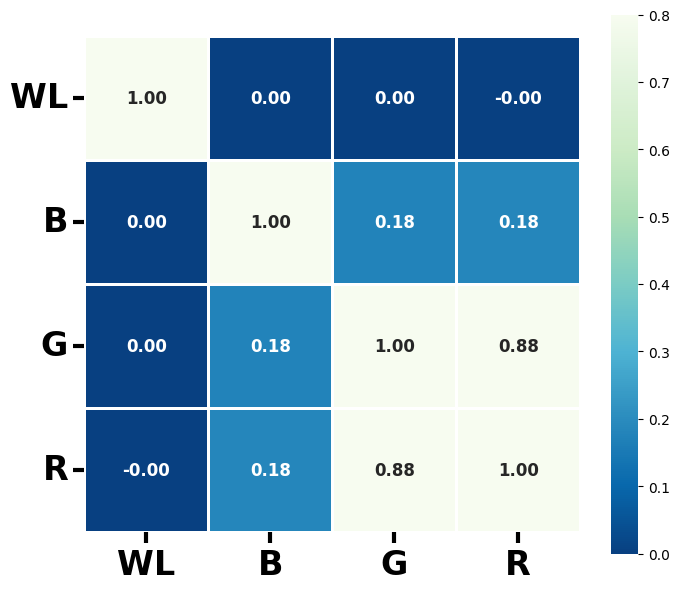

In [5]:
plot_correlation_heatmap(data_train.iloc[:, :-1])

## 2.機械学習（予測モデル）

ここでは、複数のモデルを評価するための関数`evaluate_model`を定義します。また、候補となるモデルの辞書 (`models`)
以下の7つの回帰モデルを辞書形式で定義しています。キーがモデル名で、値が対応するモデルのインスタンスです。

- **KNN**: 近傍アルゴリズムによる回帰モデル（`KNeighborsRegressor`）
- **RandomForest**: ランダムフォレスト回帰（`RandomForestRegressor`）
- **ExtraTrees**: エクストラツリーモデル（`ExtraTreesRegressor`）
- **GBDT**: 勾配ブースティング（`GradientBoostingRegressor`）
- **XGBoost**: XGBoostによる回帰モデル（`xgboost.XGBRegressor`）
- **LightGBM**: LightGBMによる回帰モデル（`lightgbm.LGBMRegressor`）
- **CatBoost**: CatBoostによる回帰モデル`）

各モデルは、パラメータを指定して初期化されています。

### 分類モデルの定義（初期設定）

In [7]:
models = {
    "KNN": KNeighborsRegressor(5),
    "RandomForest": RandomForestRegressor(n_estimators=60),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=15),
    "GBDT": GradientBoostingRegressor(n_estimators=55),
    "XGBoost": xgboost.XGBRegressor(n_estimators=300),
    "LightGBM": lightgbm.LGBMRegressor(objective='regression', num_leaves=40, learning_rate=0.02, n_estimators=400),
    "CatBoost": catboost.CatBoostRegressor(iterations=500, learning_rate=0.01, loss_function='RMSE', verbose=False)
}

In [8]:
# 評価指標の計算

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    pearson_train = np.corrcoef(y_train, pred_train)[0, 1]
    pearson_test = np.corrcoef(y_test, pred_test)[0, 1]

    MAPE_train = mean_absolute_percentage_error(y_train, pred_train)
    RMSE_train = np.sqrt(mean_squared_error(y_train, pred_train))
    MAE_train = mean_absolute_error(y_train, pred_train)

    MAPE_test = mean_absolute_percentage_error(y_test, pred_test)
    RMSE_test = np.sqrt(mean_squared_error(y_test, pred_test))
    MAE_test = mean_absolute_error(y_test, pred_test)

    print(f"{model_name} Pearson Coeffient train:", pearson_train)
    print(f"{model_name} Pearson Coeffient test:", pearson_test)
    print(f"{model_name} MAPE_train:", MAPE_train)
    print(f"{model_name} RMSE_train:", RMSE_train)
    print(f"{model_name} MAE_train:", MAE_train)
    print(f"{model_name} MAPE_test:", MAPE_test)
    print(f"{model_name} RMSE_test:", RMSE_test)
    print(f"{model_name} MAE_test:", MAE_test)
    return pred_test

### モデル構築

In [9]:
for name, model in models.items():
    model.fit(X_train, y_train)
    pred_test = evaluate_model(model, X_train, y_train, X_test, y_test, name)

KNN Pearson Coeffient train: 0.9999733584964192
KNN Pearson Coeffient test: 0.9524961678368771
KNN MAPE_train: 0.004940044213561958
KNN RMSE_train: 0.003669722032211374
KNN MAE_train: 0.001351505894355022
KNN MAPE_test: 0.1032826226868242
KNN RMSE_test: 0.14484897352436168
KNN MAE_test: 0.06877144361318925
RandomForest Pearson Coeffient train: 0.9999922118818129
RandomForest Pearson Coeffient test: 0.9711244384146213
RandomForest MAPE_train: 0.003337013207089117
RandomForest RMSE_train: 0.001987963320071545
RandomForest MAE_train: 0.00116491753570618
RandomForest MAPE_test: 0.1113163053726364
RandomForest RMSE_test: 0.1251580098023062
RandomForest MAE_test: 0.05329242033804376
ExtraTrees Pearson Coeffient train: 1.0
ExtraTrees Pearson Coeffient test: 0.980883298207361
ExtraTrees MAPE_train: 1.7816497767315826e-16
ExtraTrees RMSE_train: 1.738235822425682e-16
ExtraTrees MAE_train: 1.0349654818521772e-16
ExtraTrees MAPE_test: 0.0693968534380426
ExtraTrees RMSE_test: 0.09144407765344809
Ex

### モデル評価（クロスバリデーション評価）

7つの機械学習モデルに対して10分割交差検証（Cross-validation）を行い、結果をリストに保存します。

In [10]:
# Custom scorer for cross-validation
def pearson_correlation(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

In [11]:
# データを保持するリストを準備
results = []

# Cross-validation for all models
for name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    
    scores = cross_val_score(pipeline, 
                             X_train, 
                             y_train, 
                             scoring=make_scorer(pearson_correlation), 
                             cv=10, 
                             n_jobs=1
                            )
    
    # モデルの結果をリストに保存
    results.append({
        'Model': name,
        'Cross Validation Mean': np.mean(scores),
        'Cross Validation Std': np.std(scores),
        'Cross Validation Scores': scores
    })

    print(f"Model: {name}")
    print('Cross Validation scores: %s' % scores)
    print('Cross Validation: %.8f +/- %.8f' % (np.mean(scores), np.std(scores)))

Model: KNN
Cross Validation scores: [0.99991093 0.99990444 0.99989744 0.99990785 0.99988459 0.99991472
 0.99991077 0.99990059 0.99991698 0.99991093]
Cross Validation: 0.99990592 +/- 0.00000914
Model: RandomForest
Cross Validation scores: [0.99994397 0.9999427  0.99993105 0.99993461 0.99994267 0.999945
 0.99993774 0.99993756 0.9999374  0.99994181]
Cross Validation: 0.99993945 +/- 0.00000427
Model: ExtraTrees
Cross Validation scores: [0.99997452 0.99996479 0.99996143 0.99996939 0.99996873 0.9999747
 0.99996992 0.99997102 0.99996501 0.99997349]
Cross Validation: 0.99996930 +/- 0.00000422
Model: GBDT
Cross Validation scores: [0.97794432 0.97797655 0.97677884 0.97503527 0.97627923 0.9771299
 0.97530246 0.97741436 0.97518118 0.9754663 ]
Cross Validation: 0.97645084 +/- 0.00109493
Model: XGBoost
Cross Validation scores: [0.99984445 0.99983688 0.99982962 0.99982786 0.99984898 0.99984839
 0.99982194 0.99985163 0.99983057 0.99982175]
Cross Validation: 0.99983621 +/- 0.00001084
[LightGBM] [Info] 

In [12]:
# DataFrameに変換
df_results = pd.DataFrame(results)
df_results

,Model,Cross Validation Mean,Cross Validation Std,Cross Validation Scores
0,KNN,0.999906,0.000009,"[0.9999109310805514, 0.9999044427785987, 0.999..."
1,RandomForest,0.999939,0.000004,"[0.9999439748865855, 0.9999426960783493, 0.999..."
2,ExtraTrees,0.999969,0.000004,"[0.9999745229782682, 0.9999647946840745, 0.999..."
3,GBDT,0.976451,0.001095,"[0.9779443164723771, 0.9779765454414592, 0.976..."
4,XGBoost,0.999836,0.000011,"[0.9998444468823178, 0.9998368801816351, 0.999..."
5,LightGBM,0.999536,0.000014,"[0.999522148799676, 0.9995151491132819, 0.9995..."
6,CatBoost,0.989683,0.000348,"[0.9901770926706471, 0.9897099456050349, 0.989..."


### 最も良いモデルを選定 (Cross Validationの平均スコアが最も高いもの)

In [13]:
best_model = df_results.loc[df_results['Cross Validation Mean'].idxmax()]

print("\nBest Model:")
print(best_model)


Best Model:
Model                                                             ExtraTrees
Cross Validation Mean                                               0.999969
Cross Validation Std                                                0.000004
Cross Validation Scores    [0.9999745229782682, 0.9999647946840745, 0.999...
Name: 2, dtype: object


## 3.重要特徴量の評価
### ランダムフォレスト回帰の適用
ここでは`RandomForestRegressor` モデルを `n_estimators=60` で作成し、60本の決定木を持つランダムフォレスト回帰器を用意します。

In [14]:
# モデルの学習
rfr = RandomForestRegressor(n_estimators=60)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=60)

### 重要特徴量の抽出
`RandomForestRegressor` モデルの重要特徴量 (`feature_importances_`) を `pandas.Series` に変換して、特徴量名をインデックスとして持つシリーズを作成します。

In [15]:
# 特徴量重要度の抽出
feature_importance = pd.Series(rfr.feature_importances_, index=X_train.columns)
feature_importance

WL    0.552482
B     0.092554
G     0.074340
R     0.280624
dtype: float64

【解説】：

### `rfr.feature_importances_`
- `rfr` は `RandomForestRegressor` のインスタンスで、すでに `fit` メソッドを使って訓練されたランダムフォレストモデルです。
- `feature_importances_` は、訓練されたランダムフォレストモデルから計算される各特徴量の重要度（どれだけ予測に貢献したか）を表す属性です。これは、各特徴量に対するスコアのリストで、値が大きいほどその特徴量の重要度が高いことを示します。

### 可視化の準備
LaTeX形式の数式を文字列としてリストに格納しています。それぞれの項目は、グラフのx軸ラベルなどで使われることを目的としています。

In [16]:
x = [r'$\mathregular{WL}$', r'$\mathregular{B}$', r'$\mathregular{G}$', r'$\mathregular{R}$']
y = feature_importance.values

#### 1. `x = [...]`
- `x` はリストです。このリストには4つの文字列が含まれています。

#### 2. `r'...'` の部分
- `r` は「raw string（生文字列）」を意味します。Pythonの生文字列では、バックスラッシュ `\` をエスケープシーケンス（例: `\n` や `\t`）として扱わず、そのまま文字列の一部として扱います。ここでは、LaTeXの数式形式で使われるバックスラッシュをそのまま解釈させるために使用されています。

#### 3. `$\mathregular{...}$`
- `$...$` は、LaTeXで数式を囲むための記法です。`matplotlib` では、LaTeX形式の数式をグラフ内でレンダリングすることができます。
- `\mathregular{...}` は、LaTeXのコマンドで、指定された文字列を通常の数式記号として扱い、フォントを通常のテキストフォントに変更するものです。

#### 4. それぞれの文字列の意味
- `r'$\mathregular{WL}$'`：`WL` という文字列を数式として表示します。
- `r'$\mathregular{B}$'`：`B` という文字列を数式として表示します。
- `r'$\mathregular{G}$'`：`G` という文字列を数式として表示します。
- `r'$\mathregular{R}$'`：`R` という文字列を数式として表示します。

このリスト `x` の要素は、`matplotlib` のグラフの x 軸ラベルなどで使用される際に、LaTeX形式でフォーマットされた文字列として描画されます。具体的には、`'WL'`, `'B'`, `'G'`, `'R'` といったラベルが、LaTeXフォーマットで美しく描画されます。

例えば、このリストは以下のように `matplotlib` の `plt.xticks()` 関数などで使用され、x軸のラベルに設定されることがよくあります。

In [18]:
# 特徴量の可視化設定

def plot_feature_importance(importance, labels, filename='feature_importance.png'):
    plt.figure(figsize=(8,7))
    ax = plt.gca()

    # 軸の線幅設定
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)

    # barプロット作図
    plt.bar(labels, importance, color='blue')

    # フォントとラベルの設定
    plt.yticks(size=20, weight='black')
    plt.xticks(size=20, weight='black')
    plt.tick_params(axis='y', width=2, length=6)
    plt.tick_params(axis='x', width=2, length=6)
    
    plt.xlabel('Descriptors', fontdict={'weight': 'black', 'size': 20})
    plt.ylabel('Feature Importance', fontdict={'weight': 'black', 'size': 20})

    plt.ylim(0, 0.6)
    
    # プロットの保存と表示
    plt.savefig(filename, dpi=300)
    plt.show()

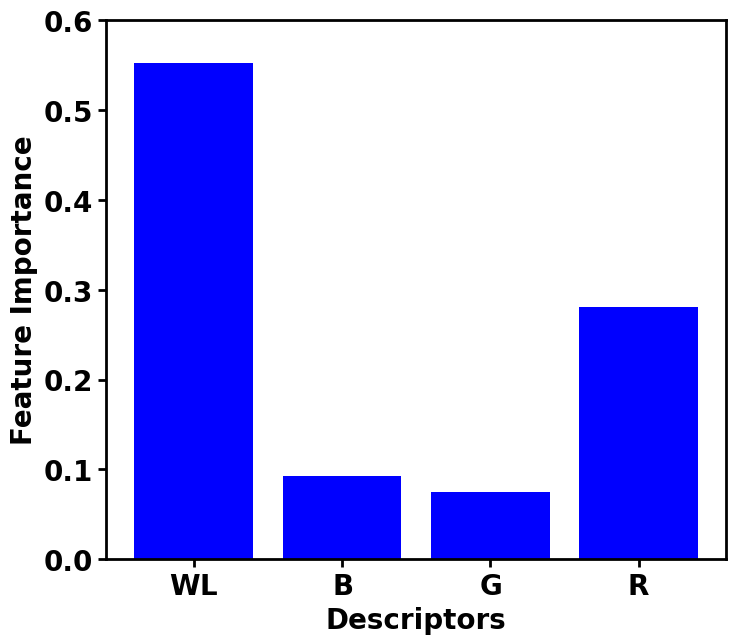

In [19]:
# プロット作成
plot_feature_importance(y, x)